# Project description

You work for the OilyGiant mining company. Your task is to find the best place for a new well.

**Steps to choose the location:**
- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.
- You have data on oil samples from three regions. Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.

**Data description**
- Geological exploration data for the three regions are stored in files:
- geo_data_0.csv. download dataset
- geo_data_1.csv. download dataset
- geo_data_2.csv. download dataset
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- product — volume of reserves in the oil well (thousand barrels).





In [50]:
#Import all libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns#visualization
sns.set(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#define most used variables
RANDOM_STATE=12345
BUDGET_IN_MILLION = 100  #The budget for development of 200 oil wells is 100 USD million.
REVENUE_PER_PRODUCT_UNIT = 4500 #One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
REVENUE_IN_MILLION = REVENUE_PER_PRODUCT_UNIT / 1000000
PRINT_SEPARATOR = '*' * 80

import sys
print (sys.version)

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]


# STEP 1 - DATA PREPROCESSING

**Project instructions**
- Download and prepare the data. 
- Explain the procedure.
- Build one dataframe for each region.
 - df0 for geo_data_0
 - df1 for geo_data_1
 - df2 for geo_data_2


**Data description**
- Geological exploration data for the three regions are stored in files:
- geo_data_0.csv. download dataset
- geo_data_1.csv. download dataset
- geo_data_2.csv. download dataset
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- product — volume of reserves in the oil well (thousand barrels).

In [51]:
#Import the file and create the dataset
path = '/datasets'
df0 = pd.read_csv(path+'/geo_data_0.csv')
df1 = pd.read_csv(path+'/geo_data_1.csv')
df2 = pd.read_csv(path+'/geo_data_2.csv')

**BUILD A RESULT DATA FRAME**
- Build a list of all dataframes for processing.
- One dataframe corresponds to one regions.
- Build a result dataframe to store the model prediction results for each dataframe.

In [52]:
#Create a dataframe to store the dataframes (df0,df1,df2) annd the source data
df_all=[df0,df1,df2]
df_all_names=['df0_geo0','df1_geo1','df2_geo2']

#Create a dataframe to dataframe name, Model name and model results
column_names = ["region","R2score","mean","rmse","Confidence_low","Confidence_up","totalGainOrLoss","profitProbability","lossProbability","lossRisk %","profitAverage","lossAverage"]
# Intitialize lists data. 

#data = [{'df': 'df0', 'df_name': 'geo_0'}, {'df': 'df1', 'df_name': 'geo_1'},{'df':'df2','df_name':'geo_2'}] 
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,region,R2score,mean,rmse,Confidence_low,Confidence_up,totalGainOrLoss,profitProbability,lossProbability,lossRisk %,profitAverage,lossAverage


In [53]:
def display_information(df):
    print('Head:')
    print()
    display(df.head())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print ('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.'.format(df.duplicated().sum()) + "\033[0m")
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

def get_percent_of_na(df):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index,s.values):
        
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent,num,num_of_nulls))
        
    if count !=0:
        print('There are {} columns with NA!'.format(count))
    else:
        print()
        print('There are no columns with NA!')

In [54]:
i=0
for df_tmp in df_all:
  print("REGION NAME: ",df_all_names[i])
  display_information(df_tmp)
  i=i+1
  print()

REGION NAME:  df0_geo0
Head:



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99990
top,bxg6G
freq,2



Columns with nulls:


,Missing Values,Percent of Nulls
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.

REGION NAME:  df1_geo1
Head:



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99996
top,wt4Uk
freq,2



Columns with nulls:


,Missing Values,Percent of Nulls
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.

REGION NAME:  df2_geo2
Head:



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99996
top,Vcm5J
freq,2



Columns with nulls:


,Missing Values,Percent of Nulls
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



# CONCLUSION:
- I don't see any outliers. 
- The only data I see problematic is the IDs are mixed case. However that shouldn't impact my analysis. Hence I leave it as is.
- There is one ID which is repeated. I will check if the entire row is the same. If yes, consider removing one row. 

In [55]:
duplicate_id_rows = df0[df0['id']=='HZww2']
display('df0 duplicate_id_rows',duplicate_id_rows)

duplicate_id_rows = df1[df1['id']=='wt4Uk']
display('df1 duplicate_id_rows',duplicate_id_rows)

duplicate_id_rows = df2[df2['id']=='Vcm5J']
display('df2 duplicate_id_rows',duplicate_id_rows)

'df0 duplicate_id_rows'

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


'df1 duplicate_id_rows'

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


'df2 duplicate_id_rows'

,id,f0,f1,f2,product
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


# CONCLUSION:

- The duplicate id rows have different values in the features set. Hence won't remove the rows.
- The only data I see problematic is the IDs are mixed case. However that shouldn't impact my analysis. Hence I leave it as is. We may remove these IDs since they don't serve any purpose in analysis.

# STEP-2: EXPLORATORY DATA ANALYSIS

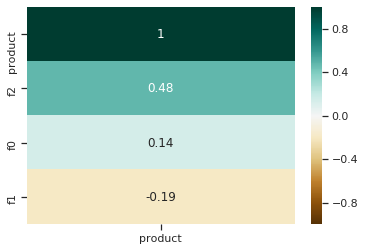

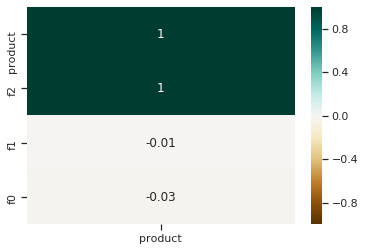

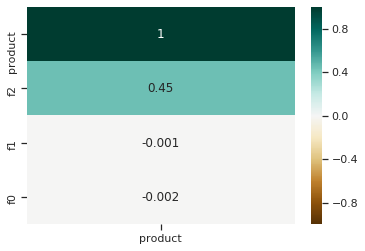

In [56]:
for df in df_all:
  heatmap = display(sns.heatmap(df.corr()[['product']].sort_values(by='product', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG'))
  plt.show()

# CONCLUSION
- The heatmap depicts that product has strong positive correlation with f2.
- It has weaker or negative correlation with f0.
- product has negative correlation with  f1


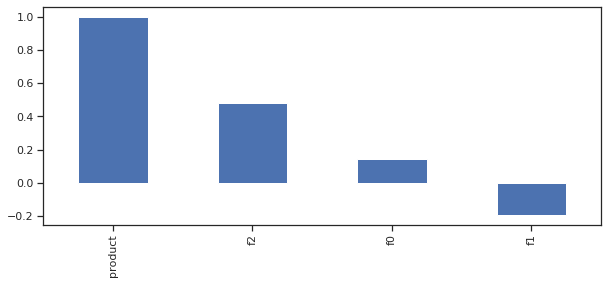

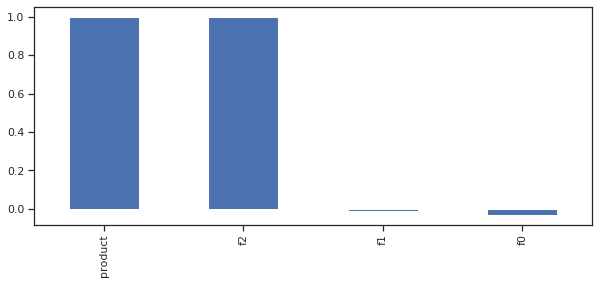

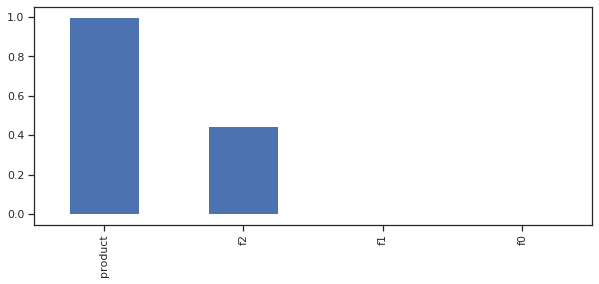

In [57]:
for df in df_all:
  plt.figure(figsize=(10,4))
  df.corr()['product'].sort_values(ascending = False).plot(kind='bar')
  plt.show()

# CONCLUSION
The BAR Chart also displays that 

f2 has high correlation with product,
f0 has a bit weaker or negative correlation.
f1 has negative correlation with product.

In [58]:
#Droping id column which will have no use in the Machine Learning
i=0
for df in df_all:
    display(df.shape)
    df_all[i]=df.drop(['id'],axis=1)
    i+=1

for df in df_all:
    display(df.shape)

(100000, 5)

(100000, 5)

(100000, 5)

(100000, 4)

(100000, 4)

(100000, 4)

# CONCLUSION
- Dropped column: id

# STEP-3: FEATURE ENGINEERING


# Train and test the model for each region:
- 2.1. Split the data into a training set and validation set at a ratio of 75:25.
- 2.2. Train the model and make predictions for the validation set.
- 2.3. Save the predictions and correct answers for the validation set.
- 2.4. Print the average volume of predicted reserves and model RMSE.
- 2.5. Analyze the results.
- FUNCTION for DEFINING TRAINING and VALIDATION SETS
- Training set is 75%, Validation set is 25% each

In [59]:
def defineTrainingValidationSets(df):
    target = df['product']
    features = df.drop(['product'] , axis=1)

    #FIRST SPLIT INTO TRAINING(75%) AND VALIDATION_TEST (25%)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

    totsize = len(df)
    print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
    print('validation set: {0:.0%}'.format(len(features_valid)/totsize),features_valid.shape,', validation target :',target_valid.shape)
    return(target,features,features_train, features_valid, target_train, target_valid)


    #Standardize the numerical features.
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()

    # < transform feature set >
    scaler.fit(features_train[numeric])
    features_train.loc[:,numeric] = scaler.transform(features_train[numeric])

    # < transform validation set >
    features_valid.loc[:,numeric] = scaler.transform(features_valid[numeric])
    #display(features_valid.head(5),features_train.head(5))
    return(target,features,features_train, features_valid, target_train, target_valid)

# STEP-4: TEST LINEAR REGRESSION ON DATASETS 
- Only linear regression is suitable for model training (the rest are not sufficiently predictable).
- Use 3 features to train your model to predict the target values. 
- I you have 3 datasets and 1  model for each dataset.
- FUNCTION FOR LINER REGRESSION
- Calculate rmse and score


In [60]:
def applyLinearRegression(features,target,features_train,target_train,features_valid,target_valid):
    method="LinearRegression"
    hyperparam = "none"
    model = LinearRegression() 
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)
    score = r2_score(target_valid,predicted_valid)
    mean = predicted_valid.mean()
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse**0.5
    return(score,mean,rmse,predicted_valid)

RESPONSE: Scaled the data using StandardScaler. Thank you.

# Calculate risks and profit for each region: 
- FUNCTION TO CALCULATE REVENUE BASED ON SAMPLING
- Calculate profit for each region:
- Use the bootstrapping technique with 1000 samples to find the distribution of profit.
- Find average profit, 95% confidence interval and risk of losses. Loss is negative profit, calculate it as a probability and then express as a percentage.
- A 95% confidence interval is used, so the values at the 2.5 and 97.5 percentiles are selected.

- In profit function we do the following:
 - Sort predictions
 - Use indexes from sorted predictions to take top 200 wells from targets
 - Calculate the revenue
 - Subtract budget from revenue to get profit
 - When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
 - The budget for development of 200 oil wells is 100 USD million.
 - One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).

In [61]:
def revenue(target_param, predictions_param, count):    
    predictions_sorted = predictions_param.sort_values(ascending=False)
    selected = target_param[predictions_sorted.index][:count]
    return  (selected.sum() * REVENUE_IN_MILLION)

In [62]:
def calculateProfits(target_valid,predicted_valid):
    state = np.random.RandomState(RANDOM_STATE)
    target_valid_reindexed = target_valid.reset_index(drop=True)  
    predicted_valid_reindexed  = pd.Series(predicted_valid)

    #display(target_valid_reindexed)
    #display(predicted_valid)
    values = []
    for i in range(1000):

        target_subsample = target_valid_reindexed.sample(n=500,replace=True,random_state=state)
        
        predictions_subsample = predicted_valid_reindexed[target_subsample.index]
        values.append(revenue(target_subsample,predictions_subsample,200))  

    values = pd.Series(values)
    #We have 1000 values of 200 regions
    #We need to find all values for losses (revenue less that 100M) and profit (revenue more than 100M)
    
    values = values - 100
    totalValues = len(values)
    totalGainOrLoss = values.mean()
    
    losses = values[values < 0] 
    profits = values[values >0] 
    nLosses = len(losses)
    nProfits = len(profits)
    
    print('STATTISTICS ON BOOTSTRAPPING: PROFIT OR LOSS in MILLIONS')
    display(values.describe())

    fig = plt.figure(figsize=(10,6))
    sns.distplot(values,axlabel="Profit or Loss in Millions",kde_kws={"lw": 3})
    plt.show()

    profitProbability = nProfits/totalValues
    lossProbability = nLosses/totalValues

    lossAverage = losses.sum()/nLosses
    profitAverage = profits.sum()/nProfits
    
    #A 95% confidence interval is used, so the values at the 2.5 and 97.5 percentiles are selected.
    lowerC = values.quantile(0.025) 
    upperC = values.quantile(.975) 

    #print(lowerC,upperC)

    print()
    return(lowerC,upperC,totalGainOrLoss,profitProbability,lossProbability,lossProbability*100,profitAverage,lossAverage,values)

# STEP-5 FUNCTION TO UPDATE RESULTS in RESULTS DATASET (df_results)
- Update results of model prediction and bootstrapping for each region in the df_results dataset.

In [63]:
def updateResults(df_name,score,mean,rmse,lowerC,upperC,totalGainOrLoss,profitProbability,lossProbability,lossRisk,profitAverage,lossAverage,df_results):
    resultRowStr= [df_name,score,mean,rmse,lowerC,upperC,totalGainOrLoss,profitProbability,lossProbability,lossRisk,profitAverage,lossAverage]
    #print(resultRowStr,df_results.columns)
    rows = [pd.Series(resultRowStr, index=df_results.columns)]
    # append the rows
    df_results=df_results.append(rows,ignore_index=True).round(decimals=2)
    # check the rows 
    return(df_results)

# STEP 6
- EVALUATE ALL DATASETS for Revenue, Profits, Confidence Intervals, Risk of Losses, Loss percentage
#Prepare for profit calculation:
- 3.1. Store all key values for calculations in separate variables.
- 3.2. Calculate the volume of reserves sufficient for developing a new well without losses. Compare the obtained value with the average volume of reserves in each region.
- 3.3. Provide the findings about the preparation for profit calculation step.
Write a function to calculate profit from a set of selected oil wells and model predictions:
- 4.1. Pick the wells with the highest values of predictions.
- 4.2. Summarize the target volume of reserves in accordance with these predictions
- 4.3. Provide findings: suggest a region for oil wells' development and justify the choice. Calculate the profit for the obtained volume of reserves.

In [64]:
def print_separator():
  print()
  print(PRINT_SEPARATOR)

In [65]:
def display_final_results(values_all,df_results,df_all_names):

    print_separator()
    print("FINAL RESULTS")
    print("METHOD USED WAS LINEAR REGRESSION ON SCALED DATA WITH NO HYPERPARAMETERS")
    print("ALL values are in Millions")
    print_separator()
    f = plt.figure(figsize=(10,6))
    
   
    sns.distplot(values_all[0],  color="blue", kde_kws={"lw": 3},axlabel="Profit or Loss in Millions",label="GEO_0")
    sns.distplot(values_all[1],  color="red", kde_kws={"lw": 3},axlabel="Profit or Loss in Millions",label="GEO_1")
    sns.distplot(values_all[2],  color="green",kde_kws={"lw": 3},axlabel="Profit or Loss in Millions", label="GEO_2")
    plt.legend()
    plt.show()   

    display(df_results)
    print_separator()


********************************************************************************
PROCESSING DATASET:  df0_geo0
training set  : 75% (75000, 3) , training target   : (75000,)
validation set: 25% (25000, 3) , validation target : (25000,)
STATTISTICS ON BOOTSTRAPPING: PROFIT OR LOSS in MILLIONS


count    1000.000000
mean        4.259385
std         2.772767
min        -3.768427
25%         2.344665
50%         4.206723
75%         6.192790
max        14.098417
dtype: float64

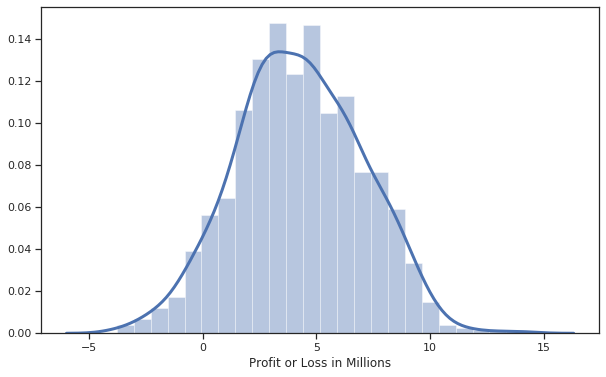

,region,R2score,mean,rmse,Confidence_low,Confidence_up,totalGainOrLoss,profitProbability,lossProbability,lossRisk %,profitAverage,lossAverage
0,df0_geo0,0.28,92.59,37.58,-1.02,9.48,4.26,0.94,0.06,6.0,4.6,-1.15



********************************************************************************
PROCESSING DATASET:  df1_geo1
training set  : 75% (75000, 3) , training target   : (75000,)
validation set: 25% (25000, 3) , validation target : (25000,)
STATTISTICS ON BOOTSTRAPPING: PROFIT OR LOSS in MILLIONS


count    1000.000000
mean        5.152228
std         2.191824
min        -1.201163
25%         3.726463
50%         5.162191
75%         6.701637
max        13.152692
dtype: float64

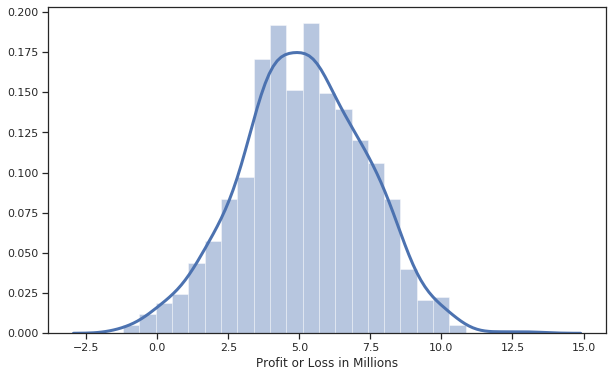

,region,R2score,mean,rmse,Confidence_low,Confidence_up,totalGainOrLoss,profitProbability,lossProbability,lossRisk %,profitAverage,lossAverage
0,df0_geo0,0.28,92.59,37.58,-1.02,9.48,4.26,0.94,0.06,6.0,4.60,-1.15
1,df1_geo1,1.00,68.73,0.89,0.69,9.32,5.15,0.99,0.01,1.0,5.21,-0.49



********************************************************************************
PROCESSING DATASET:  df2_geo2
training set  : 75% (75000, 3) , training target   : (75000,)
validation set: 25% (25000, 3) , validation target : (25000,)
STATTISTICS ON BOOTSTRAPPING: PROFIT OR LOSS in MILLIONS


count    1000.000000
mean        4.350084
std         2.828926
min        -3.976744
25%         2.475138
50%         4.389031
75%         6.381758
max        13.904547
dtype: float64

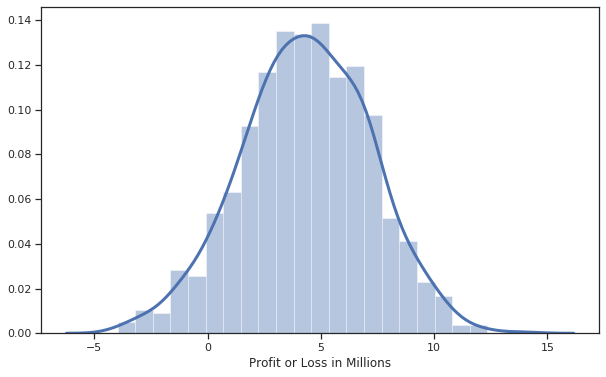

,region,R2score,mean,rmse,Confidence_low,Confidence_up,totalGainOrLoss,profitProbability,lossProbability,lossRisk %,profitAverage,lossAverage
0,df0_geo0,0.28,92.59,37.58,-1.02,9.48,4.26,0.94,0.06,6.0,4.60,-1.15
1,df1_geo1,1.00,68.73,0.89,0.69,9.32,5.15,0.99,0.01,1.0,5.21,-0.49
2,df2_geo2,0.21,94.97,40.03,-1.29,9.70,4.35,0.94,0.06,6.4,4.74,-1.33



********************************************************************************
FINAL RESULTS
METHOD USED WAS LINEAR REGRESSION ON SCALED DATA WITH NO HYPERPARAMETERS
ALL values are in Millions

********************************************************************************


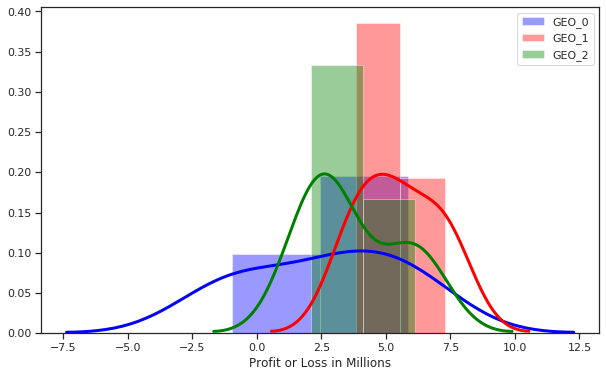

,region,R2score,mean,rmse,Confidence_low,Confidence_up,totalGainOrLoss,profitProbability,lossProbability,lossRisk %,profitAverage,lossAverage
0,df0_geo0,0.28,92.59,37.58,-1.02,9.48,4.26,0.94,0.06,6.0,4.60,-1.15
1,df1_geo1,1.00,68.73,0.89,0.69,9.32,5.15,0.99,0.01,1.0,5.21,-0.49
2,df2_geo2,0.21,94.97,40.03,-1.29,9.70,4.35,0.94,0.06,6.4,4.74,-1.33



********************************************************************************


In [66]:
#Process all datasets one by one
df_values_all=pd.DataFrame()
  
for i in range(3):
    df = df_all[i]
    df_name=df_all_names[i]
    
    print_separator()
    print("PROCESSING DATASET: ", df_name)

    #Set the training, validation and test datasets (features and target)
    target,features,features_train, features_valid, target_train, target_valid = defineTrainingValidationSets(df)
   # display(target,features,target_train,features_train)

    #Apply Linear Regression model to the dataset
    score,mean,rmse,predicted_valid = applyLinearRegression(features,target,features_train,target_train,features_valid,target_valid)

    #Apply bootstrapping to evaluate revenue, profit, loss, confidence intervals
    lowerC,upperC,totalGainOrLoss,profitProbability,lossProbability,lossRisk,profitAverage,lossAverage,values = calculateProfits(target_valid,predicted_valid)
    
    #save all valuyes in df_values_all
    df_values_all = df_values_all.append(values,ignore_index=True)
    #Save results in df_results dataframe
    df_results = updateResults(df_name,score,mean,rmse,lowerC,upperC,totalGainOrLoss,profitProbability,lossProbability,lossRisk,profitAverage,lossAverage,df_results )

    #display results
    display(df_results)
    
display_final_results(df_values_all, df_results, df_all_names)

RESPONSE: results now displayed in various stages along with distribution chart.

**RESPONSE: **
- Updated the revenue() function to return the revenue for 200 items out of 1000.
- Updated the calculateProfits() to calculate profit/loss in the 1000 vectored values, then calculate probability and percentage for losses. Now I am using all 1000 values of 200 collective regions each to find profit/loss.
- Added function displayFinalResults() to display final results and one distribution chart for all regions.
- Updated overall conclusion.
- Thank you for your valuable feedback.

# OVERALL CONCLUSION - REGION FOR DEVELOPMENT  (geo_data_1)
#OVERALL CONCLUSION - REGION FOR DEVELOPMENT  (geo_data_1)
- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.
- Provide findings: suggest a region for development of oil wells and justify the choice. 
 - df1_geo1 dataset corresponding to  geo_data_1.csv region is suggested as the region for development.
 - As per the above calculations with rmse, confidence intervals, profit and loss percentage:
 - Region: geo_data_1.csv -  R2score of 1, rmse of 0.89, Maximum profit  is between 0.69% - 9.3% with a confidence interval of 95%, Has the highest overall profit.Its lower_confidence is 0.69 and upper_confidence is 9.32. This implies that most of the revenue is resulting in profits. This is also evident from the distribution plot. 
 - Region: geo_data_0.csv - Maximum profit is between -1% - 9.5% with a confidence interval of 95%
 - Region: geo_data_2.csv - Maximum profit is between -1.3 - 9.7% with a confidence interval of 95%
 - Also as per the Exploratory Data Analysis, the F2 factor was biggest in correlation with the product, f2 correlation is 1 for geo_data_1, 0.48 for geo_data_0, 0.45 for geo_data_2. This strongly supports the conclusion that Region_1 geo_data_1 is the ideal region for development.

- To avoid risk of losses, I would strongly recommend the region: df1_geo1. It displays no losses in the 95% confidence interval.
- Although this region has slightly less %age profit in the upper_confidence interval, the avoidance of risk in the lower confidence interval and rmse, revenue, overall profits, model score make it a strong candidate for Oil Exploration and Development.
- Region geo1 has the lowest LOSS Risk %age of 1%. Other regions have LOSS RISK %age of 6%. 


# Project evaluation
- Evaluation criteria for the project.
- Here’s what the reviewers will look at when reviewing your project:
- How did you prepare the data for training?
- Have you followed all the steps of the instructions?
- Have you taken into account all the business conditions?
- What are your findings about the task study?
- Have you applied the Bootstrapping technique correctly?
- Have you suggested the best region for well development? Is the choice justified?
- Did you avoid code duplication?
- Have you kept to the project structure and kept the code neat?
- You have your takeaway sheets and chapter summaries, so you are ready to proceed to the project.

Thank you for evaluating my project.
